In this notebook, we compare the three models under a simple R&S setting.

This version will use Thompson Sampling to compare models.

In [1]:
from time import time

import torch
from botorch import fit_gpytorch_model, settings
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.test_functions import EggHolder
from botorch.utils.transforms import unnormalize, t_batch_mode_transform
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

from contextual_rs.lce_gp import LCEGP
from contextual_rs.unknown_correlation_model import UnknownCorrelationModel
from contextual_rs.rs_kg import DiscreteKG, UnknownCorrelationKG

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


def model_constructor(model_type: str):
    def model_create(X, Y):
        if model_type == "LCEGP":
            model = LCEGP(
                X.view(-1, 1), Y.view(-1, 1), categorical_cols=[0], embs_dim_list=[2]
            )
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)
            return model
        else:
            model = UnknownCorrelationModel(X, Y, update_method=model_type)
            return model
    return model_create


def main_run(
    num_alternatives: int,
    rho: float,
    num_full_train: int,
    iterations: int,
    replications: int,
    q: int = 1,
    skip_lce: int = 0,  # set 1 if we don't want to run LCEGP, else 0
):
    K = num_alternatives
    true_mean = torch.linspace(0, 1, K)
    true_cov = torch.zeros(K, K)
    for i in range(K):
        for j in range(K):
            true_cov[i, j] = torch.tensor(rho).pow(abs(i - j))
    sampling_post = MultivariateNormal(true_mean, true_cov)

    train_X = torch.arange(num_alternatives, dtype=torch.float).repeat(num_full_train)
    train_Y = sampling_post.rsample(torch.Size([num_full_train])).view(-1).detach()

    labels = ["LCEGP", "moment-matching", "KL", "moment-KL"]

    model_constructor_list = [
        model_constructor(m_type) for m_type in labels
    ]

    all_alternatives = torch.arange(num_alternatives, dtype=torch.float).view(-1, 1)

    predicted_bests = [torch.zeros(replications, iterations) for _ in range(4)]
    start = time()

    for rep in range(replications):
        X_list = [train_X.clone() for _ in range(4)]
        Y_list = [train_Y.clone() for _ in range(4)]
        for i in range(iterations):
            if i == 0:
                print(f"Starting replication {rep}, iteration {i}, time: {time()-start}")
            next_points = torch.zeros(4, q)
            for j in range(skip_lce, 4):
                constructor = model_constructor_list[j]
                model = constructor(X_list[j], Y_list[j])

                if j:
                    predicted_bests[j][rep, i] = model.theta.argmax()
                    posterior_t = model.posterior(None)
                    posterior_samples = torch.tensor(posterior_t.rvs(size=q))
                    max_samples = posterior_samples.argmax(dim=-1)

                else:
                    predicted_bests[j][rep, i] = model.posterior(all_alternatives).mean.argmax()
                    posterior_samples = model.posterior(all_alternatives).rsample(
                        sample_shape=torch.Size([q])
                    ).detach()
                    max_samples = posterior_samples.argmax(dim=-2).squeeze()

                next_points[j] = max_samples.to(dtype=torch.float)

            full_eval = sampling_post.rsample().view(-1).detach()
            next_evals = full_eval[next_points.long()]

            for j in range(skip_lce, 4):
                X_list[j] = torch.cat([X_list[j], next_points[j].view(-1)], dim=-1)
                Y_list[j] = torch.cat([Y_list[j], next_evals[j].view(-1)], dim=-1)

    plot_values = [
        sampling_post.mean[tmp.long()].detach().mean(dim=0) for tmp in predicted_bests
    ]
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')

    for i in range(skip_lce, 4):
        plt.plot(plot_values[i], label=labels[i])
    plt.axhline(sampling_post.mean.max(), label="true_best")
    plt.grid()
    plt.legend()
    plt.show()


# debug run
# main_run(
#     num_alternatives=4,
#     rho=0.5,
#     num_full_train=3,
#     iterations=3,
#     replications=1,
#     q=2,
# )

Starting replication 0, iteration 0, time: 4.7206878662109375e-05
Starting replication 1, iteration 0, time: 61.10022830963135
Starting replication 2, iteration 0, time: 121.62138795852661
Starting replication 3, iteration 0, time: 172.86990451812744
Starting replication 4, iteration 0, time: 224.48454904556274


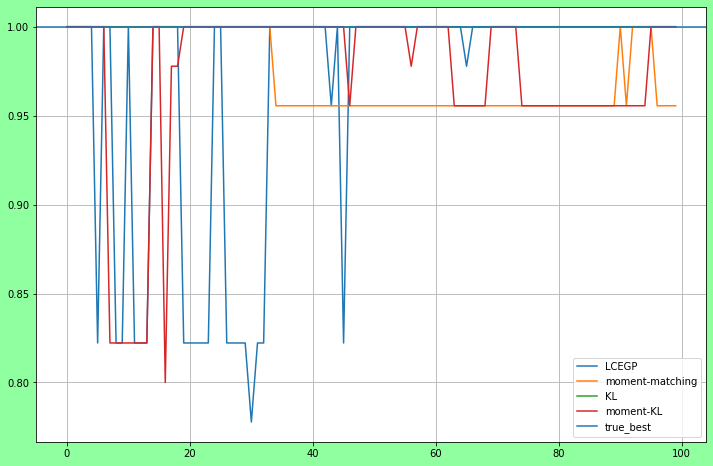

In [2]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.314018249511719e-05
Starting replication 1, iteration 0, time: 63.03439021110535
Starting replication 2, iteration 0, time: 126.8272602558136
Starting replication 3, iteration 0, time: 188.94535493850708
Starting replication 4, iteration 0, time: 254.67589569091797


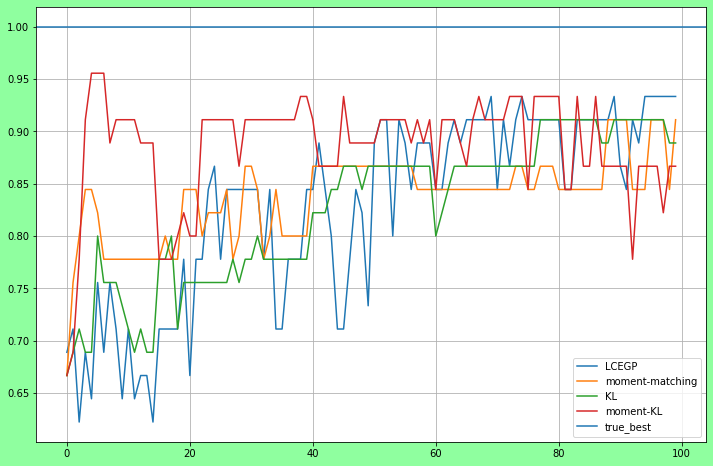

In [3]:
main_run(
    num_alternatives=10,
    rho=0.5,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.409385681152344e-05
Starting replication 1, iteration 0, time: 156.19464802742004
Starting replication 2, iteration 0, time: 310.33424854278564
Starting replication 3, iteration 0, time: 469.16385436058044
Starting replication 4, iteration 0, time: 642.8065567016602


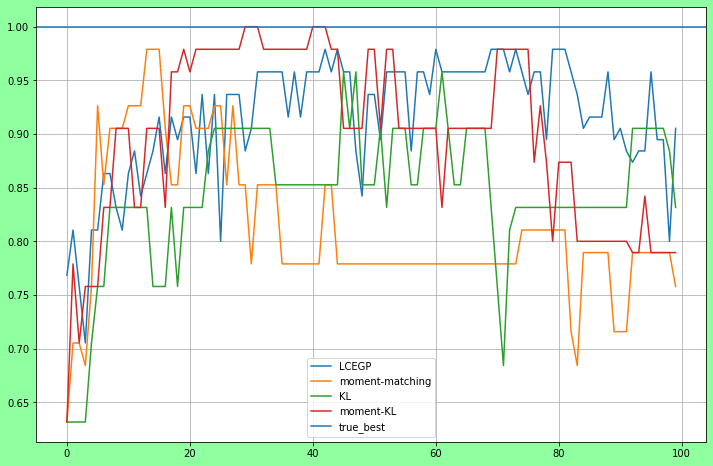

In [4]:
main_run(
    num_alternatives=20,
    rho=0.5,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.2901763916015625e-05
Starting replication 1, iteration 0, time: 147.93953895568848
Starting replication 2, iteration 0, time: 315.2606897354126
Starting replication 3, iteration 0, time: 482.0544798374176
Starting replication 4, iteration 0, time: 640.5808455944061


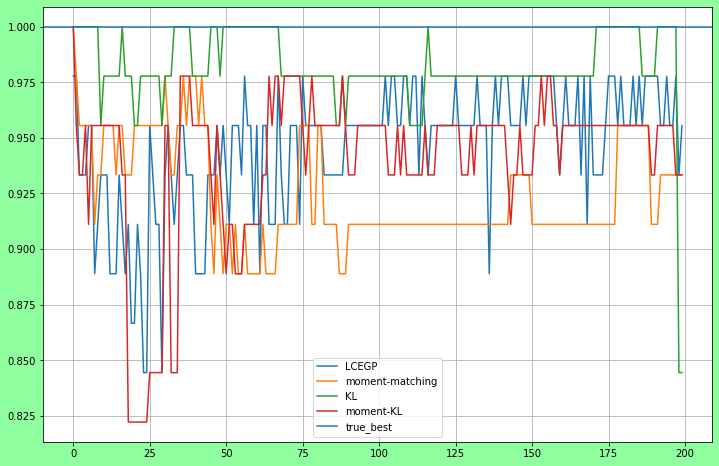

In [5]:
main_run(
    num_alternatives=10,
    rho=0.1,
    num_full_train=5,
    iterations=200,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.3855438232421875e-05
Starting replication 1, iteration 0, time: 110.05682134628296
Starting replication 2, iteration 0, time: 228.34408974647522
Starting replication 3, iteration 0, time: 349.642169713974
Starting replication 4, iteration 0, time: 448.13548374176025


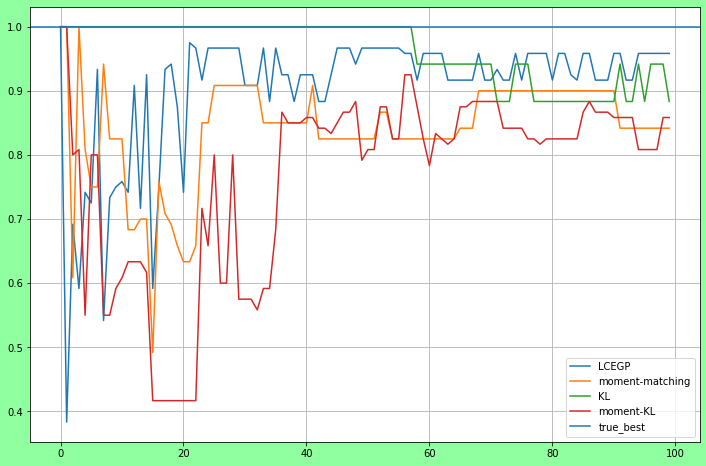

In [6]:
main_run(
    num_alternatives=25,
    rho=0.9,
    num_full_train=5,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.8623809814453125e-05
Starting replication 1, iteration 0, time: 147.8020040988922
Starting replication 2, iteration 0, time: 306.5490605831146
Starting replication 3, iteration 0, time: 463.4650659561157
Starting replication 4, iteration 0, time: 611.2834060192108


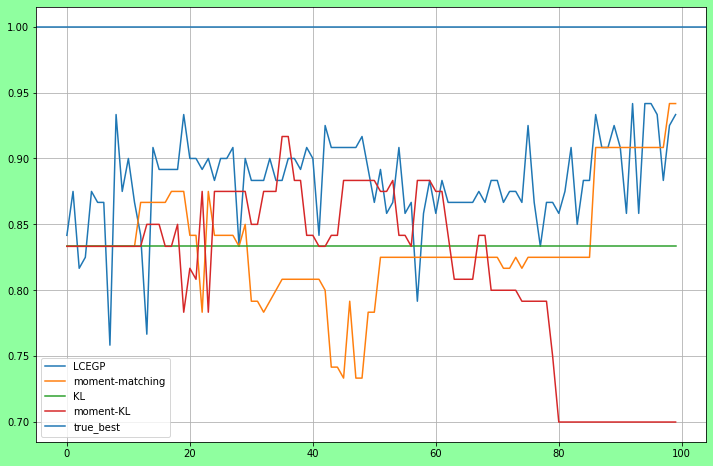

In [7]:
main_run(
    num_alternatives=25,
    rho=0.9,
    num_full_train=10,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.933906555175781e-05
Starting replication 1, iteration 0, time: 119.29661226272583
Starting replication 2, iteration 0, time: 248.19393634796143
Starting replication 3, iteration 0, time: 352.93093085289
Starting replication 4, iteration 0, time: 475.26760601997375
Starting replication 5, iteration 0, time: 607.4155898094177
Starting replication 6, iteration 0, time: 755.9383299350739
Starting replication 7, iteration 0, time: 884.5698232650757
Starting replication 8, iteration 0, time: 1012.2624635696411
Starting replication 9, iteration 0, time: 1149.4418709278107


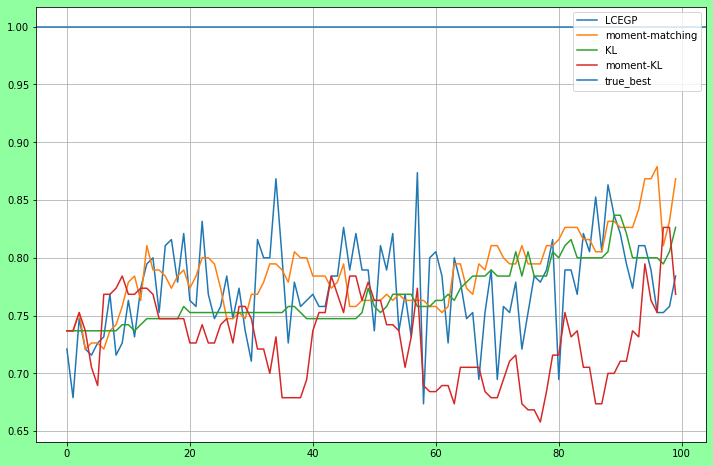

In [8]:
main_run(
    num_alternatives=20,
    rho=0.8,
    num_full_train=5,
    iterations=100,
    replications=10,
)

Starting replication 0, iteration 0, time: 5.5789947509765625e-05
Starting replication 1, iteration 0, time: 315.4893636703491
Starting replication 2, iteration 0, time: 617.0585129261017
Starting replication 3, iteration 0, time: 882.759624004364
Starting replication 4, iteration 0, time: 1162.052170753479
Starting replication 5, iteration 0, time: 1463.5971484184265
Starting replication 6, iteration 0, time: 1738.4381122589111
Starting replication 7, iteration 0, time: 2031.0153379440308
Starting replication 8, iteration 0, time: 2345.933378458023
Starting replication 9, iteration 0, time: 2652.9077768325806


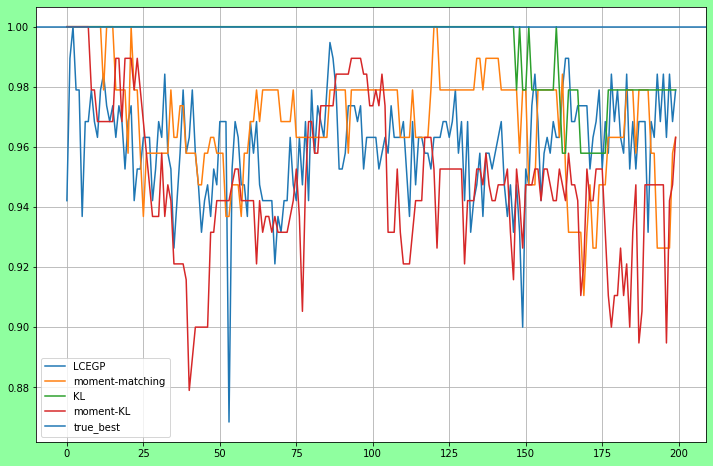

In [9]:
main_run(
    num_alternatives=20,
    rho=0.7,
    num_full_train=5,
    iterations=200,
    replications=10,
)


Starting replication 0, iteration 0, time: 3.266334533691406e-05
Starting replication 1, iteration 0, time: 526.977516412735
Starting replication 2, iteration 0, time: 1024.1847803592682
Starting replication 3, iteration 0, time: 1511.4555933475494
Starting replication 4, iteration 0, time: 2020.6630997657776


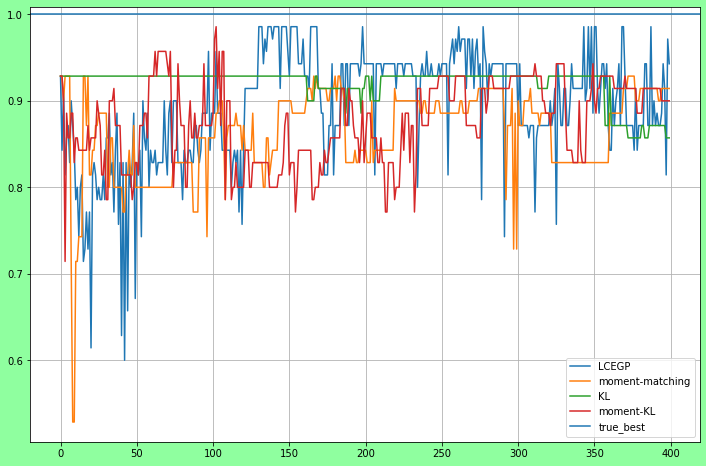

In [11]:
main_run(
    num_alternatives=15,
    rho=0.7,
    num_full_train=3,
    iterations=400,
    replications=5 ,
)

Starting replication 0, iteration 0, time: 3.552436828613281e-05
Starting replication 1, iteration 0, time: 384.2151253223419
Starting replication 2, iteration 0, time: 802.6106278896332
Starting replication 3, iteration 0, time: 1146.9484233856201
Starting replication 4, iteration 0, time: 1460.4306259155273


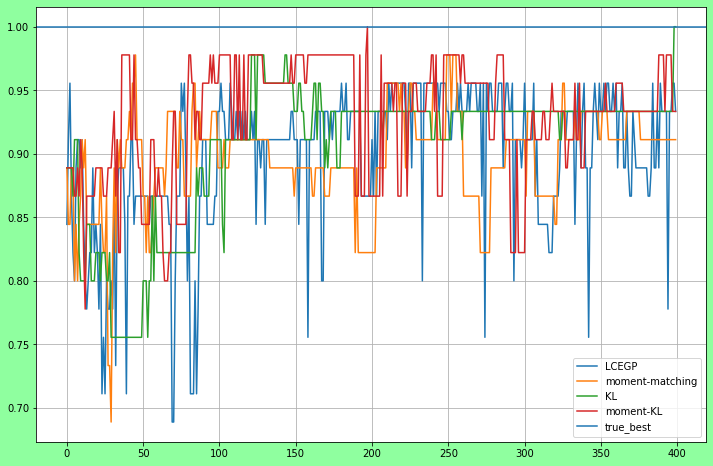

In [12]:
main_run(
    num_alternatives=10,
    rho=0.2,
    num_full_train=3,
    iterations=400,
    replications=5 ,
)

Starting replication 0, iteration 0, time: 3.337860107421875e-05
Starting replication 1, iteration 0, time: 20.152865648269653
Starting replication 2, iteration 0, time: 44.47965168952942
Starting replication 3, iteration 0, time: 70.34424543380737
Starting replication 4, iteration 0, time: 93.45254683494568


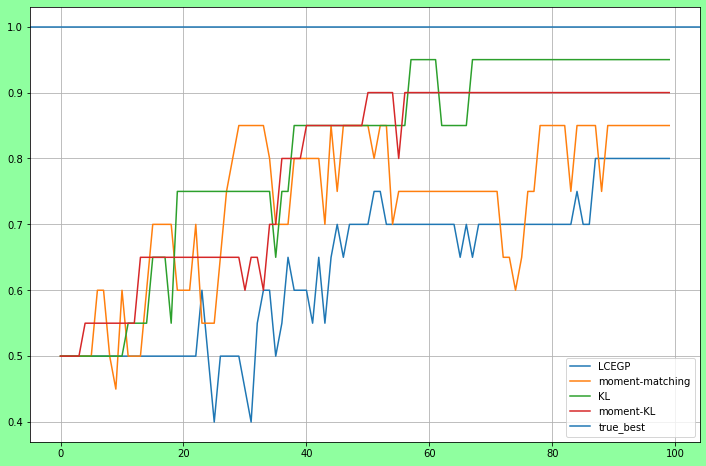

In [13]:
main_run(
    num_alternatives=5,
    rho=0.5,
    num_full_train=3,
    iterations=100,
    replications=5,
)

Starting replication 0, iteration 0, time: 3.361701965332031e-05
Starting replication 1, iteration 0, time: 264.8001356124878
Starting replication 2, iteration 0, time: 507.56228399276733
Starting replication 3, iteration 0, time: 760.0974977016449
Starting replication 4, iteration 0, time: 1029.107703924179


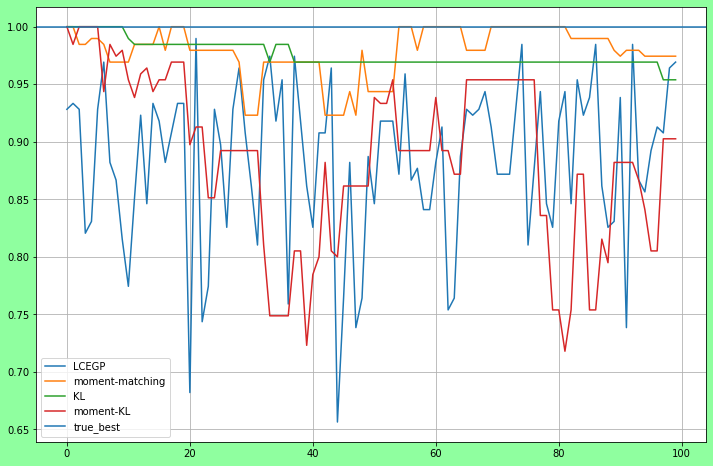

In [14]:
main_run(
    num_alternatives=40,
    rho=0.1,
    num_full_train=5,
    iterations=100,
    replications=5,
)


Starting replication 0, iteration 0, time: 3.4809112548828125e-05
Starting replication 1, iteration 0, time: 77.23665428161621
Starting replication 2, iteration 0, time: 138.16901898384094
Starting replication 3, iteration 0, time: 213.4008297920227
Starting replication 4, iteration 0, time: 277.1218943595886
Starting replication 5, iteration 0, time: 341.2401349544525
Starting replication 6, iteration 0, time: 410.2477447986603
Starting replication 7, iteration 0, time: 483.470064163208
Starting replication 8, iteration 0, time: 563.6254959106445
Starting replication 9, iteration 0, time: 628.0301358699799


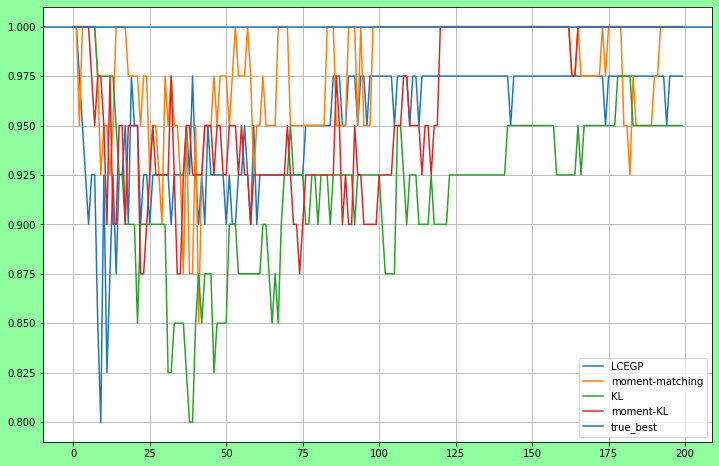

In [15]:
main_run(
    num_alternatives=5,
    rho=0.5,
    num_full_train=3,
    iterations=200,
    replications=10,
)